In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import numpy as np
from app.utils import preprocessing

In [29]:
data = preprocessing.load_processed_data()

df_customer = data['customer']
df_order = data['order']
df_geo = data['geo']
df_order_item = data['order_item']
df_product = data['product']
df_order_payment = data['order_payment']
df_order_review = data['order_review']
df_seller = data['seller']

/Users/dsagher/Library/CloudStorage/Dropbox/Documents/school/fall 2025/CMSE 830/midterm_project_2/app/utils/preprocessing.py:282: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  'order': pd.read_csv(DATA_PROCESSED_DIR / 'order.csv', parse_dates=['purchase_timestamp', 'approved_timestamp', 'delivered_carrier_date', 'delivered_customer_date', 'purchase_month']),


In [30]:
orders_merged = (df_order.merge(df_order_item, on='order_id', how='inner')
    .merge(df_order_payment, on='order_id', how='inner')
    .merge(df_order_review, on='order_id', how='left'))
numeric_cols = ['price', 'freight_value', 'delivery_time', 'review_score', 'weight', 'volume']


<Axes: >

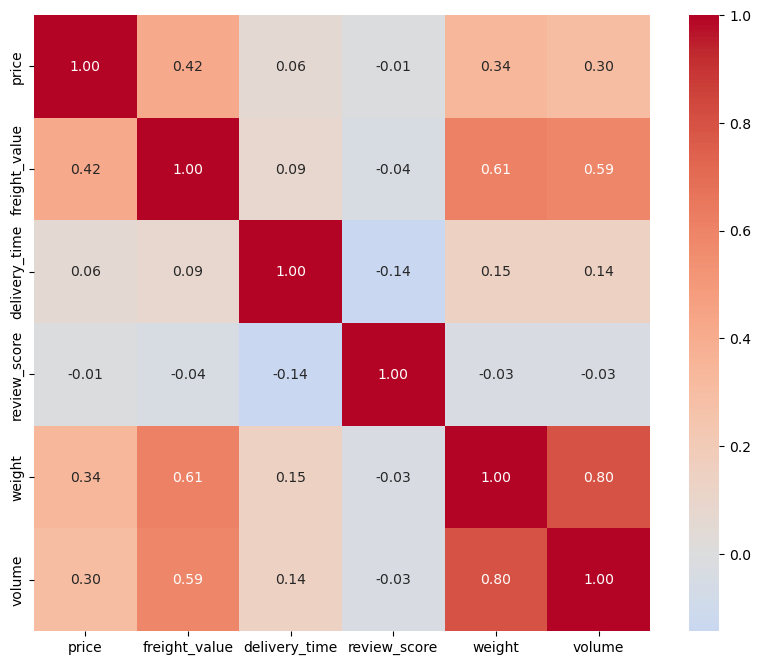

In [31]:
corr_data = orders_merged[numeric_cols].corr()
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_data, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, ax=ax, square=True)


In [32]:
def correlate(df: pd.DataFrame, x: str, y:str) -> tuple:
    mask = df[[x, y]].notnull().all(axis=1)
    x_var = df.loc[mask, x]
    y_var = df.loc[mask, y]
    r, p = stats.pearsonr(x_var,y_var)
    r, p = round(r,2), round(p,2)
    return r, p, r**2


print("---------------------Freight Value X _______---------------------------")

r, p , r_sq = correlate(orders_merged, 'freight_value', 'price')
print(f'Freight value X Price: r: {r}, p-val: {p}, r^2: {r_sq}')

r, p , r_sq = correlate(orders_merged, 'freight_value', 'weight')
print(f'Freight value X weight: r: {r}, p-val: {p}, r^2: {r_sq}')

r, p , r_sq = correlate(orders_merged, 'freight_value', 'volume')
print(f'Freight value X volume: r: {r}, p-val: {p}, r^2: {r_sq}')

print()

print("---------------------Delivery Time X _______---------------------------")

r, p , r_sq = correlate(orders_merged, 'delivery_time', 'volume')
print(f'Delivery time X volume: r: {r}, p-val: {p}, r^2: {r_sq}')

r, p , r_sq = correlate(orders_merged, 'delivery_time', 'weight')
print(f'Delivery time X weight: r: {r}, p-val: {p}, r^2: {r_sq}')

r, p , r_sq = correlate(orders_merged, 'delivery_time', 'review_score')
print(f'Delivery time X review_score: r: {r}, p-val: {p}, r^2: {r_sq}')


---------------------Freight Value X _______---------------------------
Freight value X Price: r: 0.42, p-val: 0.0, r^2: 0.17639999999999997
Freight value X weight: r: 0.61, p-val: 0.0, r^2: 0.3721
Freight value X volume: r: 0.59, p-val: 0.0, r^2: 0.34809999999999997

---------------------Delivery Time X _______---------------------------
Delivery time X volume: r: 0.14, p-val: 0.0, r^2: 0.019600000000000003
Delivery time X weight: r: 0.15, p-val: 0.0, r^2: 0.0225
Delivery time X review_score: r: -0.14, p-val: 0.0, r^2: 0.019600000000000003


> **Observations:**
> - **33.6%** and **36%** of the variance in freight value can be explained by product volume and weight, respectively (**p < 0.001**). 14% of freight value variance can be attributed to price, as well. Bigger, heavier, expensive products are more expensive to ship. 
> - Delivery time is only slightly **negatively correlated** with review score (**p < 0.001**), but only 2.5% of the variance can be explained. 
> - Relationship between delivery time and product dimensions is neglegible (**< 5%**). This suggests delivery time is driven by other factors, such as **distance, logistic efficiency, or regional infrastructure**.

---

> **Next Steps**  
> - Identify which localities are purchasing higher freight value items. 
> - Recommend cost-saving measures to reduce shipping overhead.  
> - Find correlations between distance between buyer, seller, and delivery time. If a strong relationship exists, move forward with predictive modeling.


In [50]:
# The mask is correct—this creates a boolean Series for negative delivery times.
# But just defining the mask alone doesn't change the values. You need to assign the new value.
# Use:
df_order.loc[df_order['delivery_time'] < 0, 'delivery_time'] = 0


Text(5, 7, 'p-value: 0.00, r-value: -0.43, r^2: 0.18')

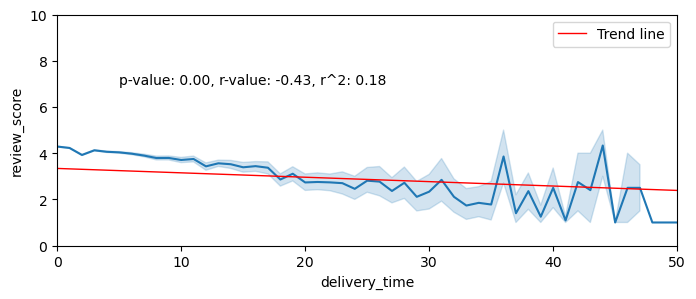

In [74]:
from scipy.stats import linregress

order_cols = ['order_id', 'delivery_time']
review_cols = ['order_id', 'review_score']

source = df_order[order_cols].merge(df_order_review[review_cols], on='order_id', how='left')

fig, ax = plt.subplots(figsize=(8, 3))
# ax, fig = set_ax_fig_style(title='', xaxis_label='Review Score', yaxis_label='Delivery Time', ax=ax, fig=fig, color='white')

# Barplot for average delivery time per review score
sns.lineplot(data=source, x='delivery_time', y='review_score', ax=ax, color='C0')

means = source.groupby("delivery_time")["review_score"].mean().reset_index()
x = means["delivery_time"]
y = means["review_score"]
slope, intercept, r_value, p_value, std_err = linregress(x, y)
trend_y = slope * x + intercept
ax.plot(x, trend_y, color='red', linewidth=1, label='Trend line')
ax.legend()

plt.ylim(0, 10)
plt.xlim(0, 50)
plt.text(5, 7, f"p-value: {p_value:.2f}, r-value: {r_value:.2f}, r^2: {r_value**2:.2f}")
